<a href="https://colab.research.google.com/github/dfsj66011/learning_note/blob/master/tensorflow_tutorial/basic_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 影评文本分类

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

此笔记本会将文本形式的影评分为“正面”或“负面”影评。这是一个二元分类（又称为两类分类）的示例，也是一种重要且广泛适用的机器学习问题。

我们将使用 [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) 数据集，其中包含来自互联网电影数据库的 50000 条影评文本。我们将这些影评拆分为训练集（25000 条影评）和测试集（25000 条影评）。训练集和测试集之间达成了平衡，意味着它们包含相同数量的正面和负面影评。

此笔记本使用的是 [tf.keras](https://www.tensorflow.org/guide/keras)，它是一种用于在 TensorFlow 中构建和训练模型的高阶 API。有关使用 tf.keras 的更高级文本分类教程，请参阅 [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/) 文本分类指南。


In [4]:
# keras.datasets.imdb is broken in 1.13 and 1.14, by np 1.16.3
!pip install tf_nightly

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.15.0-dev20190724


## 下载 IMDB 数据集
TensorFlow 中包含 IMDB 数据集。我们已对该数据集进行了预处理，将影评（字词序列）转换为整数序列，其中每个整数表示字典中的一个特定字词。

以下代码会将 IMDB 数据集下载到您的计算机上（如果您已下载该数据集，则会使用缓存副本）：

In [0]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

参数 `num_words=10000` 会保留训练数据中出现频次在前 10000 位的字词。为确保数据规模处于可管理的水平，罕见字词将被舍弃。



## 探索数据
我们花点时间来了解一下数据的格式。该数据集已经过预处理：每个样本都是一个整数数组，表示影评中的字词。每个标签都是整数值 0 或 1，其中 0 表示负面影评，1 表示正面影评。

In [7]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


影评文本已转换为整数，其中每个整数都表示字典中的一个特定字词。第一条影评如下所示：

In [8]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


影评的长度可能会有所不同。以下代码显示了第一条和第二条影评中的字词数。由于神经网络的输入必须具有相同长度，因此我们稍后需要解决此问题。

In [9]:
len(train_data[0]), len(train_data[1])

(218, 189)

### 将整数转换回字词
了解如何将整数转换回文本可能很有用。在以下代码中，我们将创建一个辅助函数来查询包含整数到字符串映射的字典对象：

In [0]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

现在，我们可以使用 decode_review 函数显示第一条影评的文本：

In [11]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 准备数据
影评（整数数组）必须转换为张量，然后才能馈送到神经网络中。我们可以通过以下两种方法实现这种转换：

* 对数组进行独热编码，将它们转换为由 0 和 1 构成的向量。例如，序列 \[3, 5\] 将变成一个 10000 维的向量，除索引 3 和 5 转换为 1 之外，其余全转换为 0。然后，将它作为网络的第一层，一个可以处理浮点向量数据的密集层。不过，这种方法会占用大量内存，需要一个大小为 `num_words * num_reviews` 的矩阵。

* 或者，我们可以填充数组，使它们都具有相同的长度，然后创建一个形状为 `max_length * num_reviews` 的整数张量。我们可以使用一个能够处理这种形状的嵌入层作为网络中的第一层。

在本教程中，我们将使用第二种方法。

由于影评的长度必须相同，我们将使用 [pad_sequences](https://keras.io/preprocessing/sequence/#pad_sequences) 函数将长度标准化：


In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

现在，我们来看看样本的长度：

In [13]:
len(train_data[0]), len(train_data[1])

(256, 256)

并检查（现已填充的）第一条影评：

In [14]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 构建模型
神经网络通过堆叠层创建而成，这需要做出两个架构方面的主要决策：

* 要在模型中使用多少个层？
* 要针对每个层使用多少个隐藏单元？

在本示例中，输入数据由字词-索引数组构成。要预测的标签是 0 或 1。接下来，我们为此问题构建一个模型：

In [15]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

W0725 06:28:23.726053 139973314385792 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0725 06:28:23.748047 139973314385792 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


按顺序堆叠各个层以构建分类器：

1. 第一层是 Embedding 层。该层会在整数编码的词汇表中查找每个字词-索引的嵌入向量。模型在接受训练时会学习这些向量。这些向量会向输出数组添加一个维度。生成的维度为：`(batch, sequence, embedding)`。
2. 接下来，一个 `GlobalAveragePooling1D` 层通过对序列维度求平均值，针对每个样本返回一个长度固定的输出向量。这样，模型便能够以尽可能简单的方式处理各种长度的输入。
3. 该长度固定的输出向量会传入一个全连接 (Dense) 层（包含 16 个隐藏单元）。
4. 最后一层与单个输出节点密集连接。应用 `sigmoid` 激活函数后，结果是介于 0 到 1 之间的浮点值，表示概率或置信水平。


### 隐藏单元
上述模型在输入和输出之间有两个中间层（也称为“隐藏”层）。输出（单元、节点或神经元）的数量是相应层的表示法空间的维度。换句话说，该数值表示学习内部表示法时网络所允许的自由度。

如果模型具有更多隐藏单元（更高维度的表示空间）和/或更多层，则说明网络可以学习更复杂的表示法。不过，这会使网络耗费更多计算资源，并且可能导致学习不必要的模式（可以优化在训练数据上的表现，但不会优化在测试数据上的表现）。这称为过拟合，我们稍后会加以探讨。

### 损失函数和优化器
模型在训练时需要一个损失函数和一个优化器。由于这是一个二元分类问题且模型会输出一个概率（应用 S 型激活函数的单个单元层），因此我们将使用 `binary_crossentropy` 损失函数。

该函数并不是唯一的损失函数，例如，您可以选择 `mean_squared_error`。但一般来说，`binary_crossentropy` 更适合处理概率问题，它可测量概率分布之间的“差距”，在本例中则为实际分布和预测之间的“差距”。

稍后，在探索回归问题（比如预测房价）时，我们将了解如何使用另一个称为均方误差的损失函数。

现在，配置模型以使用优化器和损失函数：

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

W0725 06:28:29.898743 139973314385792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 创建验证集
在训练时，我们需要检查模型处理从未见过的数据的准确率。我们从原始训练数据中分离出 10000 个样本，创建一个验证集。（为什么现在不使用测试集？我们的目标是仅使用训练数据开发和调整模型，然后仅使用一次测试数据评估准确率。）

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 训练模型
用有 512 个样本的小批次训练模型 40 个周期。这将对 `x_train` 和 `y_train` 张量中的所有样本进行 40 次迭代。在训练期间，监控模型在验证集的 10000 个样本上的损失和准确率：

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

W0725 06:28:36.891551 139973314385792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:457: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 56us/sample - loss: 0.6916 - acc: 0.5420 - val_loss: 0.6895 - val_acc: 0.6035
Epoch 2/40
15000/15000 [==============================] - 1s 48us/sample - loss: 0.6855 - acc: 0.7030 - val_loss: 0.6812 - val_acc: 0.7308
Epoch 3/40
15000/15000 [==============================] - 1s 45us/sample - loss: 0.6726 - acc: 0.7498 - val_loss: 0.6650 - val_acc: 0.7535
Epoch 4/40
15000/15000 [==============================] - 1s 45us/sample - loss: 0.6501 - acc: 0.7613 - val_loss: 0.6393 - val_acc: 0.7604
Epoch 5/40
15000/15000 [==============================] - 1s 46us/sample - loss: 0.6171 - acc: 0.7913 - val_loss: 0.6048 - val_acc: 0.7848
Epoch 6/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.5755 - acc: 0.8126 - val_loss: 0.5647 - val_acc: 0.8027
Epoch 7/40
15000/15000 [==============================] - 1s 46us/sample - loss: 0.5290 - acc: 0.8267 - val_loss: 0.

## 评估模型
我们来看看模型的表现如何。模型会返回两个值：损失（表示误差的数字，越低越好）和准确率。

In [19]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 38us/sample - loss: 0.3288 - acc: 0.8721
[0.3287867703437805, 0.87212]


使用这种相当简单的方法可实现约 87% 的准确率。如果采用更高级的方法，模型的准确率应该会接近 95%。

## 创建准确率和损失随时间变化的图
`model.fit()`` 返回一个 `History` 对象，该对象包含一个字典，其中包括训练期间发生的所有情况：

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

一共有 4 个条目：每个条目对应训练和验证期间的一个受监控指标。我们可以使用这些指标绘制训练损失与验证损失图表以进行对比，并绘制训练准确率与验证准确率图表：

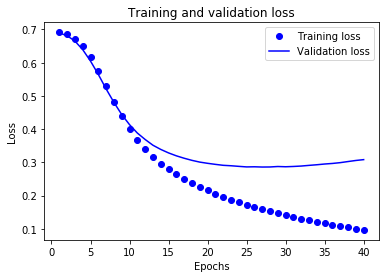

In [21]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

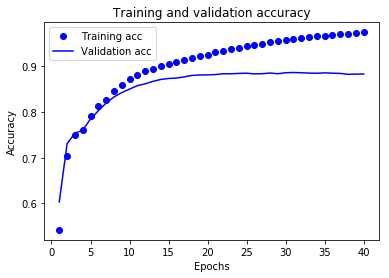

In [22]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

在该图表中，圆点表示训练损失和准确率，实线表示验证损失和准确率。

可以注意到，训练损失随着周期数的增加而降低，训练准确率随着周期数的增加而提高。在使用梯度下降法优化模型时，这属于正常现象 - 该方法应在每次迭代时尽可能降低目标值。

验证损失和准确率的变化情况并非如此，它们似乎在大约 20 个周期后达到峰值。这是一种过拟合现象：模型在训练数据上的表现要优于在从未见过的数据上的表现。在此之后，模型会过度优化和学习特定于训练数据的表示法，而无法泛化到测试数据。

对于这种特殊情况，我们可以在大约 20 个周期后停止训练，防止出现过拟合。稍后，您将了解如何使用回调自动执行此操作。